# SWC on Colab

This notebook explores ways to scalably process `*.swc` neuron skeleton files, on Colab. This documents the trial and errors along the way to working out some code to package up in a module for use in the rest of the Reconstrue stack.

## On Colab Means 

"On Colab" means it works on Colab, but the notebooks have also been tested to work on JupyterLab. So, this is a Jupyter notebook that will some assembly will work on JupyerLab but it works out-of-the-box on Colab. In this feature space, Colab is simply the strongest free Jupyter hosting service i.e. the "on Colab" part is simply a diffusion of innovation feature, not the main technical deploy target, although it is expected that most usage will occur on Colab, ergo optimize for Colab (certain amounts of memory, certains GPUs, etcetera).

## Use cases

- 2D projection, no depth perception parallaxis ray tracing
  - Make on big image
  - Cutouts and image tiling for `tf.data` to use
- 3D rendering
- Interactive, full-screen volumetric navigation

## Codebases explored

There are some very nice tools which can render SWCs, although for licensing purposed not all can be included in the Reconstrue stack. This tire kicking survey will be limited in scope to source code that ticks all the following (not so controversial yet focues) boxes:
- Source code must be licensed liberally (Apache, MIT, BSD, etc.)
- Must have Python interfaces
- Must work in JupyterLab
- Must work in Colab

After the above prerequisite check, tires will be kicked. The goal is to find scalable tools for various use cases, then package them up as part of the Reconstrue stack for later pip installing.

### Set up

### Allen Institute tools

The Allen Institute has the Allen SDK, which is probably a pretty good reference for parsing their files and loading it into some
First thing to do is what The Allen has in their own SDK docs: [Cell Types examples](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/cell_types.html#Cell-Morphology-Reconstructions). 

In [5]:
!pip3 install -q allensdk

     |████████████████████████████████| 1.5MB 1.4MB/s 
     |████████████████████████████████| 42.5MB 101kB/s 
     |████████████████████████████████| 1.2MB 47.0MB/s 
     |████████████████████████████████| 7.4MB 40.0MB/s 
     |████████████████████████████████| 4.3MB 53.6MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 2.9MB 39.6MB/s 
     |████████████████████████████████| 10.4MB 31.4MB/s 
     |████████████████████████████████| 71kB 6.3MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 3.4MB 43.0MB/s 
     |████████████████████████████████| 256kB 41.0MB/s 
     |████████████████████████████████| 153kB 52.2MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 
     |████████████████████████████████| 552kB 33.5MB/s 
ER

But the SDK doesn't have dedicated machinery for viewing the SWCs. They do have some demo code for how to render an SWC via Matplotlib, which is great pedogoically. Next, let's dial that in for performance, somehow worked out "on Colab."

In [7]:
!pip3 install pandas

In [0]:
from google.colab.data_table import DataTable
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns


#### SWC file internals
SWC is an ASCII text file format. 

[AllenSDK on SWC file format spec](https://alleninstitute.github.io/AllenSDK/cell_types.html). 
>The SWC file format is a white-space delimited text file with a standard set of headers. The file lists a set of 3D neuronal compartments, each of which has:


Column | Data Type |Description
-- | -- | --
id | string | compartment ID
type | integer | compartment type
x|float|3D compartment position (x)
y|float|3D compartment position (y)
z|float|3D compartment position (z)
radius|float|compartment radius
parent|string|parent compartment ID

>Comment lines begin with a ‘#’. Reconstructions in the Allen Cell Types Database can contain the following compartment types:

Type|Description
--|--
0|unknown
1|soma
2|axon
3|basal dendrite
4|apical dendrite



Let's see what The Allen puts in those SWC files.



#### Download SWC

In the AllenSDK docs there are multiple examples indicating that SWC files can be downloaded via:
```
tp://api.brain-map.org/api/v2/well_known_file_download/<some_id>
```
Note that `some_id` is not a cell ID, rather it is the ID of the `*.swc` file. A random valid URL is:
> [http://api.brain-map.org/api/v2/well_known_file_download/491119517](http://api.brain-map.org/api/v2/well_known_file_download/491119517)


In [3]:
src_url = "http://api.brain-map.org/api/v2/well_known_file_download/491119517"
swc_file_name = "/content/sample.swc" # /content is default dir

downloaded_doc = requests.get(src_url)
open(swc_file_name, 'wb').write(downloaded_doc.content)

95686

#### Plot skeleton

(Reconstrue has a separate notebook, [allensdk_on_colab.ipynb](https://colab.research.google.com/github/JohnTigue/colab-utils/blob/master/tools/allensdk_on_colab.ipynb), which deals with nothing except deploying AllenSDK on Colab. That notebook goes into the topic deeper than neccessary here but if complications arise on this front, it has various debug utilities.)

Total number of compartents about to (slowly) plot: 2193


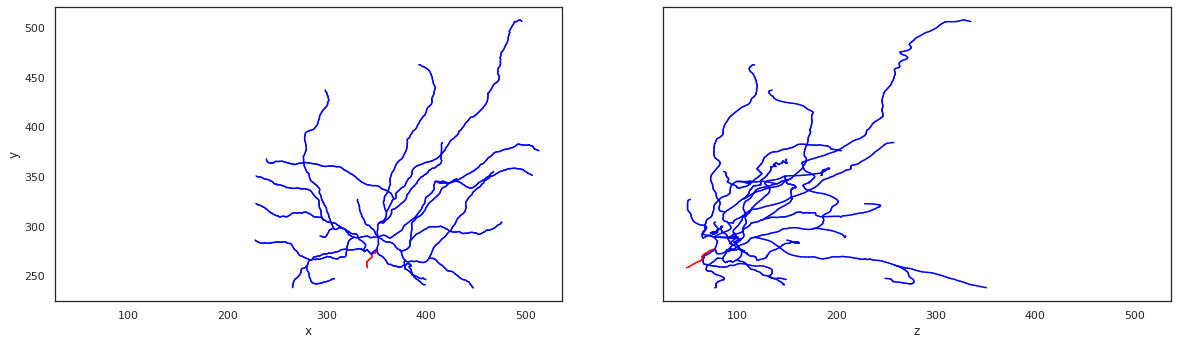

CPU times: user 5.62 s, sys: 63.8 ms, total: 5.69 s
Wall time: 5.71 s


In [18]:
%%time

from allensdk.core.swc import read_swc
from allensdk.core.swc import Marker

# https://alleninstitute.github.io/AllenSDK/_modules/allensdk/core/swc.html
morphology = read_swc(swc_file_name)
print("Total number of compartents about to (slowly) plot: %d" % len(morphology.compartment_list))

sns.set(style="white")

fig, axes = plt.subplots(1, 2, figsize=(20,20), sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box')
axes[1].set_aspect('equal', 'box') # 'box-forced'

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        if c["type"] == 2:
            skeleton_color = "red"
        else:
            skeleton_color = "blue"
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color=skeleton_color)
        # TODO: clean up this stretch factor & axis
        axes[1].plot([3.5 * n['z'], 3.5 * c['z']], [n['y'], c['y']], color=skeleton_color)

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
# TODO: legend of blue & red. Title.
plt.show()
pass # suppress <output noise> TODO: not supressing the <Figure size ... message


# TODO: save axex[0] to fileystem, then load in Plotly image viewer for zoom & pan

So, that shows folks how to use `allensdk` to get a SWC file and render it via Python.

Nonetheless, the code rather slow. As is `plot()` is being called on SWC segment at a time. Perhaps there a way to pass arrays to `plot()`?

### Pandas

One way to "pass arrays" would be to load the data into a Pandas DataFrame. Pandas and Matplotlib are supposedly well-integrated.

The skeleton files, `*.swc`, are textual and can be loaded into a DataFrame via `readcsv()`


In [16]:
print("SWC filename: %s" % swc_file_name)


SWC filename: /content/sample.swc


In [17]:
!head -5 {swc_file_name}


# generated by Vaa3D Plugin sort_neuron_swc
# source file(s): C:/Users/alexh/Desktop/Check then delete/Sst-IRES-Cre_Ai14_IVSCC_-167636.04.01.01_475125280_p.swc_Z_T10.swc
# id,type,x,y,z,r,pid
1 1 351.4368 288.9744 21.84 5.1218 -1
2 3 355.7485 290.5886 20.9126 0.2796 1


The hashtags are supposed to be comment header, so code should ignore the first three lines. Basically, an SWC file is similar to a CSV file: textual, line-oriented but with spaces for separators rather than commas. Colab has a custom DataTable, so load the SWC data structure into a DataTable.



In [10]:
# Load data from SWC file into a Panda's DataFrame, the view via google.colab.data_table.DataTable


segments = pd.read_csv(swc_file_name, sep=" ", names=["id", "type", "x", "y", "z", "r", "pid"], skiprows=[0,1,2], index_col=0)
segments.dtypes

type      int64
x       float64
y       float64
z       float64
r       float64
pid       int64
dtype: object

In [12]:
DataTable(segments)
#segments

,type,x,y,z,r,pid
id,,,,,,
1,1,351.4368,288.9744,21.8400,5.1218,-1
2,3,355.7485,290.5886,20.9126,0.2796,1
3,3,356.8765,290.7179,20.4691,0.3559,2
4,3,358.0045,290.5966,20.2896,0.4449,3
5,3,359.0719,290.2374,20.0491,0.5084,4
...,...,...,...,...,...,...
2189,3,331.6605,322.7075,14.3144,0.2924,2188
2190,3,331.2189,323.7623,14.3482,0.3051,2189
2191,3,330.8173,324.8331,14.4005,0.2924,2190


The column `pid` is for parent ID. Notice how the row with id==1 has `pid` of -1, meaning it is the root/soma, and the tree grows off it; all other rows' `pid` will have a positive integer, a key to the `id` of its parent in the tree.

So each row/segment defines its parent ID segment, the endpoint of which is uses at the start point (x,y,z) of this row's 3D line segment, and this row defines the other end of this segment (x,y,z). 

The column `r` is for the radius. In the case of this dataset, the radii seem to actually represent the diameter of the reconstructed neurites. These skeletons are not just stick figure graphs; each segment has meat, the volume defined by `r`. 

This will be very useful for treating the skeletons as a source of ground truth data. Those radii can be turned into a mask or a mesh and be used as feedback labels for training classifier as to a voxel being inside or outside a cell's membrane.

**Essentially, the core SWC data structure is a 3D tree of spheres located at (`x`, `y`, `z`) and of size `r`. For rendering, edges between any 2 spheres are skinned in a straight tube which at its ends has the same diameter as that of the sphere it ends at.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98deffa748>]],
      dtype=object)

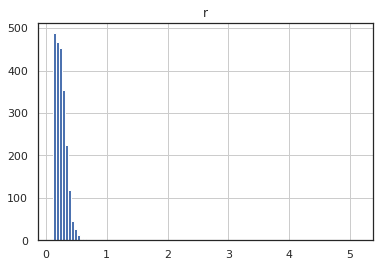

In [14]:
# TODO: plot out x,y,z histograms
#       https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html
segments.hist(column='r', bins=100)

### Find skeleton's bounding box

Below, this bounding box can be used to crop plate images (raw or projections) to the region of interest. The format for the cropbox is how much to crop from each side: ((top, bottom), (left, right))

In [9]:
maxs = segments.max(axis=0)
mins = segments.min(axis=0)

plate_width = conclusions["plate_size"][0]
plate_height = conclusions["plate_size"][1]
crop_top = mins["y"]
crop_right = plate_width - maxs["x"]
crop_bottom = plate_height - maxs["y"]
crop_left = mins["x"]

skeletons_crop_box = ((crop_top, crop_bottom), (crop_left, crop_right))

NameError: ignored

# TODO:

### Experimental: Plotly 3D 



#### Scatter plot
Render SWC files using Plotly's 3D Scatter.

Just point looks OK. Clearly the second one, the line segment version needs more love. 


In [0]:
import plotly.express as px
#iris = px.data.iris()

fig = px.scatter_3d(segments, x='x', y='y', z='z',
              color='type', size='r', size_max=18,
              opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [0]:
import plotly.graph_objects as go
import numpy as np

# Helix equation
t = np.linspace(0, 10, 50)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(x=segments['x'], y=segments['y'], z=segments['z'],
                                   mode='lines+markers',
                                   marker=dict(size=1, color=0, colorscale='Viridis', opacity=0.8)
                                   )


   ])
fig.show()

#### Streamtubes

[Streamtune API docs](https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Streamtube.html)




In [0]:
import plotly
plotly.__version__

# Streamtube API probing



In [0]:
# Peek at a bsasic demo driving CSV file
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')
DataTable(df)

In [0]:
# via https://plotly.com/python/v3/streamtube-plot/#starting-position-and-segments
from plotly.offline import iplot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-basic.csv')

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
#    starts = dict(
#        x = [80] * 16,
#        y = [20,30,40,50] * 4,
#        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
#    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")

In [0]:
# https://plotly.com/python/streamtube-plot/

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

x, y, z = np.mgrid[0:10, 0:10, 0:10]
x = x.flatten()
y = y.flatten()
z = z.flatten()

print(y) 

u = np.zeros_like(x)
v = np.zeros_like(y)
w = z**2

fig = make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d':True}]])

fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=v, w=w), 1, 1)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=w, v=v, w=u), 1, 2)
fig.add_trace(go.Streamtube(x=x, y=y, z=z, u=u, v=w, w=v), 1, 3)

fig.update_layout(scene_camera_eye=dict(x=2, y=2, z=2),
                  scene2_camera_eye=dict(x=2, y=2, z=2),
                  scene3_camera_eye=dict(x=2, y=2, z=2))
fig.show()

In [0]:
# https://plotly.com/python/v3/streamtube-plot/#basic-streamtube-plot
import plotly.graph_objs as go

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/streamtube-wind.csv').drop(['Unnamed: 0'],axis=1)

data = [go.Streamtube(
    x = df['x'],
    y = df['y'],
    z = df['z'],
    u = df['u'],
    v = df['v'],
    w = df['w'],
    starts = dict(
        x = [80] * 16,
        y = [20,30,40,50] * 4,
        z = [0,0,0,0,5,5,5,5,10,10,10,10,15,15,15,15]
    ),
    sizeref = 0.3,
    colorscale = 'Portland',
    showscale = False,
    maxdisplayed = 3000
)]

layout = go.Layout(
    scene = dict(
        aspectratio = dict(
            x = 2,
            y = 1,
            z = 0.3
        )
    ),
    margin = dict(
        t = 20,
        b = 20,
        l = 20,
        r = 20
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="streamtube wind")